### LSTMで予測を行ったとき

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [2]:
ad = pd.read_csv("入場者数_編集.csv")
ad.columns = ['ds','y']

In [3]:
ad['ds'] = pd.to_datetime(ad['ds'])
ad.info()
ad

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2040 non-null   datetime64[ns]
 1   y       2040 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 32.0 KB


,ds,y
0,2016-04-01,125
1,2016-04-02,502
2,2016-04-03,318
3,2016-04-04,190
4,2016-04-05,298
...,...,...
2035,2021-10-27,104
2036,2021-10-28,138
2037,2021-10-29,98
2038,2021-10-30,208


In [4]:
ad = ad.drop(range(1370,2040))
ad

,ds,y
0,2016-04-01,125
1,2016-04-02,502
2,2016-04-03,318
3,2016-04-04,190
4,2016-04-05,298
...,...,...
1365,2019-12-27,78
1366,2019-12-28,191
1367,2019-12-29,0
1368,2019-12-30,0


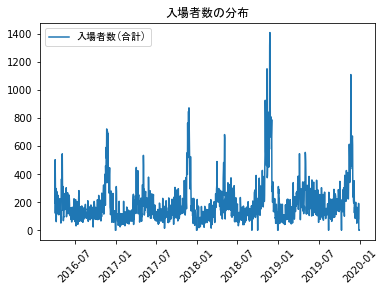

In [5]:
plt.plot(ad['ds'],ad['y'])
plt.title("入場者数の分布",fontname="MS Gothic")
plt.legend(["入場者数(合計)"], prop={"family":"MS Gothic"})
plt.xticks(rotation=45)
plt.show()

In [6]:
# 変換
dataset = ad.y.values #NumPy配列へ変換
dataset = dataset.astype('float32')    #実数型へ変換
dataset = np.reshape(dataset, (-1, 1)) #1次元配列を2次元配列へ変換
dataset #確認

array([[125.],
       [502.],
       [318.],
       ...,
       [  0.],
       [  0.],
       [  0.]], dtype=float32)

In [7]:
# ラグ付きデータセット生成関数
def gen_dataset(dataset, lag_max):
    X, y = [], []
    for i in range(len(dataset) - lag_max):
        a = i + lag_max
        X.append(dataset[i:a, 0]) #ラグ変数
        y.append(dataset[a, 0])   #目的変数
    return np.array(X), np.array(y)

In [8]:
# ラグ付きデータセットの生成
lag_max = 365
X, y = gen_dataset(dataset, lag_max)
print('X:',X.shape) #確認
print('y:',y.shape) #確認

X: (1005, 365)
y: (1005,)


In [9]:
y

array([295., 447., 278., ...,   0.,   0.,   0.], dtype=float32)

In [10]:
test_length = 365
X_train_0 = X[:-test_length,:] #学習データ
X_test_0 = X[-test_length:,:]  #テストデータ
y_train_0 = y[:-test_length] #学習データ
y_test_0 = y[-test_length:]  #テストデータ
y_train = y_train_0.reshape(-1,1)
y_test = y_test_0.reshape(-1,1)

In [11]:
# 正規化（0-1の範囲にスケーリング）
## 目的変数y
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train = scaler_y.fit_transform(y_train)
## 説明変数X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_0 = scaler_X.fit_transform(X_train_0)
X_test_0 = scaler_X.transform(X_test_0)

In [12]:
# モデル構築用にデータを再構成（サンプル数、タイムステップ, 特徴量数）
X_train = np.reshape(X_train_0, (X_train_0.shape[0], 1,X_train_0.shape[1]))
X_test = np.reshape(X_test_0, (X_test_0.shape[0], 1,X_test_0.shape[1]))
print('X_train:',X_train.shape) #確認
print('X_test:',X_test.shape) #確認

X_train: (640, 1, 365)
X_test: (365, 1, 365)


In [13]:
# モデル定義
model = Sequential()
model.add(LSTM(300,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
# コンパイル
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
# モデルの視覚化
plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [26]:
#EaelyStoppingの設定
early_stopping =  EarlyStopping(monitor='val_loss',
                                min_delta=0.0,
                                patience=2)
# 学習の実行
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=256,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=1, 
                    shuffle=False)

Epoch 1/100
2/2 [==============================] - 0s 149ms/step - loss: 0.0048 - accuracy: 0.0059 - val_loss: 0.0284 - val_accuracy: 0.0391
Epoch 2/100
2/2 [==============================] - 0s 79ms/step - loss: 0.0043 - accuracy: 0.0059 - val_loss: 0.0242 - val_accuracy: 0.0391
Epoch 3/100
2/2 [==============================] - 0s 86ms/step - loss: 0.0033 - accuracy: 0.0059 - val_loss: 0.0205 - val_accuracy: 0.0391
Epoch 4/100
2/2 [==============================] - 0s 86ms/step - loss: 0.0034 - accuracy: 0.0059 - val_loss: 0.0189 - val_accuracy: 0.0391
Epoch 5/100
2/2 [==============================] - 0s 85ms/step - loss: 0.0037 - accuracy: 0.0059 - val_loss: 0.0187 - val_accuracy: 0.0391
Epoch 6/100
2/2 [==============================] - 0s 83ms/step - loss: 0.0032 - accuracy: 0.0059 - val_loss: 0.0200 - val_accuracy: 0.0391
Epoch 7/100
2/2 [==============================] - 0s 90ms/step - loss: 0.0028 - accuracy: 0.0059 - val_loss: 0.0218 - val_accuracy: 0.0391


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300)               799200    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 799,501
Trainable params: 799,501
Non-trainable params: 0
_________________________________________________________________


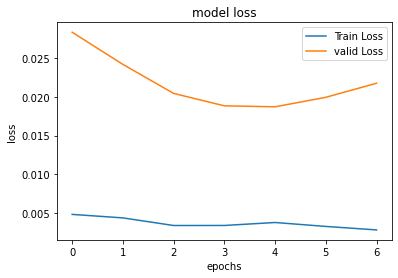

In [27]:
# 学習結果の出力
model.summary()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='valid Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

12/12 [==============================] - 0s 6ms/step
RMSE:
84.24971
MAE:
61.57973
MAPE:
7545836600000000.0


<AxesSubplot:>

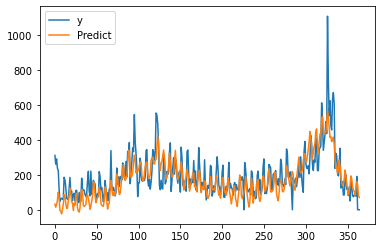

In [28]:
# テストデータの目的変数を予測
y_test_pred = model.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred)
# テストデータの目的変数と予測結果を結合
df_test = pd.DataFrame(np.hstack((y_test,y_test_pred)),
                       columns=['y','Predict'])
# 指標出力
print('RMSE:')
print(np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MAE:')
print(mean_absolute_error(y_test, y_test_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(y_test, y_test_pred)) 
# グラフ化
df_test.plot(kind='line')